In [7]:
import numpy as np
from matplotlib import pyplot as plt
import pickle, os
import pandas as pd
from tqdm import tqdm 

## Load Important Function

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [3]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

In [24]:
def state_to_index_vectorized(all_state):
    """
    Converts a (N, M, 2) array of states into (N, M) indices in [0..7].

    Assumes:
      - The first entry is a binary bit (0 or 1).
      - The second entry is an integer in [0..3].
      - If any of the two entries is NaN, the output is NaN for that row.

    Parameters
    ----------
    all_state : array-like
        An array of shape (N, M, 2).

    Returns
    -------
    indexed_states : ndarray
        A float array of shape (N, M). Valid entries are in the range [0..7].
        Entries with NaNs in the input remain NaN.
    """
    all_state_array = np.array(all_state, dtype=float)

    if all_state_array.ndim != 3 or all_state_array.shape[-1] != 2:
        raise ValueError(f"Unexpected shape: {all_state_array.shape}, expected (N, M, 2).")

    # NaN handling
    nan_mask = np.isnan(all_state_array).any(axis=-1)
    valid_mask = ~nan_mask

    # Prepare output
    indexed_states = np.full(all_state_array.shape[:-1], np.nan, dtype=float)

    # Compute index: 4 * binary_bit + discrete_value
    weights = np.array([4, 1], dtype=float)
    valid_data = all_state_array[valid_mask]
    results = valid_data @ weights

    indexed_states[valid_mask] = results

    return indexed_states

In [25]:
def index_to_state(index):
    """
    Converts an index (0-7) into a (2,) array:
      - The first element is a binary bit (0 or 1)
      - The second element is an integer in [0..3]

    This reverses the mapping from:
        index = 4 * binary_bit + value_in_0_to_3

    Parameters
    ----------
    index : int
        Integer in [0, 7]

    Returns
    -------
    state : np.ndarray
        Array of shape (2,) — [binary_bit, value]
    """
    if not (0 <= index < 8):
        raise ValueError(f"Index out of range: {index}. Expected 0–7.")

    value = index % 4
    binary_bit = index // 4

    return np.array([binary_bit, value], dtype=int)


In [16]:
import numpy as np
from tqdm import tqdm

def calculate_conform_p(trajs, conform_num):
    """
    Calculates the cumulative average population of each conformational state over time,
    excluding NaN values in the trajectory.

    Parameters
    ----------
    trajs : np.ndarray
        A 1D array of shape (timesteps,), where each value is either an integer in 
        [0, conform_num-1] or NaN (for missing data).

    conform_num : int
        The total number of conformational states.

    Returns
    -------
    conform_population : np.ndarray
        Array of shape (conform_num, valid_timesteps) — cumulative average population per conformation.
    """
    trajs = np.asarray(trajs)

    # Only keep valid time steps (non-NaN)
    valid_mask = ~np.isnan(trajs)
    trajs_clean = trajs[valid_mask]
    n_time = trajs_clean.shape[0]

    conform_population = np.zeros((conform_num, n_time), dtype=float)

    for conform_state in range(conform_num):
        match_mask = (trajs_clean == conform_state).astype(float)  # shape: (n_time,)

        cumulative_counts = np.cumsum(match_mask)  # shape: (n_time,)
        time_steps = np.arange(1, n_time + 1)      # shape: (n_time,)

        cumulative_proportions = cumulative_counts / time_steps  # shape: (n_time,)
        conform_population[conform_state] = cumulative_proportions

    #print('Conform population shape:', conform_population.shape)

    return conform_population


## The Trans Population overtime Plot

In [4]:
save_dir = 'omega_data'
all_omega = Data.load(f"{save_dir}/all_omega.pkl").array_list  # This is an (85, x, 3) array
# Convert each array in the list to float
all_omega = [arr.astype(float) for arr in all_omega]

# Apply omega2cistrans() to each array in all_omega
all_cistrans = [omega2cistrans(arr) for arr in all_omega]

# Print shape of the first converted array for verification
print(f"First array shape after conversion: {all_cistrans[0].shape}")

First array shape after conversion: (9002, 3)


In [5]:
# Find the minimum x-dimension across all arrays
min_x = min(arr.shape[0] for arr in all_cistrans)

print(f"Shortest x in all_cistrans: {min_x}")

Shortest x in all_cistrans: 3001


In [8]:
# Define paths
traj_path = '../PROJ12462traj'
log_path = '../log'

all_state = []

# Iterate over RUN and CLONE indices
for r in range(2, 3):  # Only r=2 for now
    for c in range(100):  # Iterate over c=0 to c=99
        csv_log = f"{log_path}/RUN{r}_CLONE{c}_log.csv"
        input_xtc_file = f"{traj_path}/r{r}c{c}_inte.xtc"

        # Corrected condition: Check if either file is missing
        if not os.path.exists(csv_log) or not os.path.exists(input_xtc_file):
            print(f"Missing file(s): {input_xtc_file if not os.path.exists(input_xtc_file) else ''}")
            print(f"Missing log file(s): {csv_log if not os.path.exists(csv_log) else ''}")
            continue

        # Load log and convert states
        df_log = pd.read_csv(csv_log, header=0)
        log = df_log.iloc[:, 0].values  # Convert to NumPy array
        all_state.append(log)

all_state

Missing file(s): ../PROJ12462traj/r2c8_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c32_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c46_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c48_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c49_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c57_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c59_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c77_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c79_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c87_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c91_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c93_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c95_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c96_inte.xtc
Missing log file(s): 
Missing

[array([0, 2, 1, ..., 2, 3, 2]),
 array([0, 1, 3, ..., 1, 2, 1]),
 array([0, 1, 3, ..., 0, 1, 1]),
 array([0, 2, 0, ..., 1, 1, 0]),
 array([0, 2, 1, ..., 2, 2, 2]),
 array([0, 2, 1, ..., 0, 1, 1]),
 array([0, 2, 1, ..., 3, 1, 2]),
 array([0, 3, 2, ..., 3, 2, 2]),
 array([0, 3, 0, ..., 3, 1, 2]),
 array([0, 2, 1, ..., 0, 1, 0]),
 array([0, 2, 0, ..., 3, 3, 0]),
 array([0, 2, 3, ..., 2, 3, 3]),
 array([0, 2, 2, ..., 0, 0, 1]),
 array([0, 3, 2, ..., 3, 0, 0]),
 array([0, 1, 3, ..., 0, 1, 1]),
 array([0, 2, 3, ..., 1, 0, 1]),
 array([0, 2, 1, ..., 3, 2, 3]),
 array([0, 2, 0, ..., 3, 2, 3]),
 array([0, 1, 3, ..., 3, 3, 3]),
 array([0, 1, 3, ..., 1, 0, 0]),
 array([0, 2, 1, ..., 1, 1, 1]),
 array([0, 3, 0, ..., 1, 1, 0]),
 array([0, 1, 1, ..., 3, 3, 1]),
 array([0, 1, 0, ..., 2, 1, 2]),
 array([0, 1, 1, ..., 3, 3, 2]),
 array([0, 2, 3, ..., 1, 2, 2]),
 array([0, 2, 0, ..., 1, 0, 1]),
 array([0, 2, 3, ..., 0, 2, 1]),
 array([0, 1, 1, ..., 0, 2, 1]),
 array([0, 2, 2, ..., 3, 2, 3]),
 array([0,

In [10]:
import numpy as np

unique_states = np.unique(all_state[9])
print(unique_states)


[0 1 2 3]


## Create a new data with 85, x, 4 (binary cis/trans state + lambda state)

In [12]:
# Assuming all_cistrans and all_state are lists of numpy arrays
new_all = []

for i in range(len(all_cistrans)):  # Loop over 85 trajectories
    x_len = all_cistrans[i].shape[0]  # Get the x dimension from all_cistrans

    # Trim all_state[i] to match the first x_len frames
    state_trimmed = all_state[i][:x_len]  # Ensure same length along x

    # Reshape state to (x, 1) if necessary
    state_trimmed = state_trimmed.reshape(-1, 1)  # Ensure shape (x, 1)

    # Concatenate along the last axis to get (x, 4)
    combined = np.concatenate((all_cistrans[i], state_trimmed), axis=1)

    # Append to new list
    new_all.append(combined)

new_all[4]

array([[1, 1, 1, 0],
       [1, 0, 0, 2],
       [1, 0, 1, 1],
       ...,
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 0, 1, 0]])

## Make a whole np traj.shape (85, 37002, 4) with nan, and separa them into 3 res, make it (3, 85, 37002, 2)

In [13]:
ntraj = len(new_all)
print(ntraj)

# Find the longest traj
maxlength = max( [ len(new_all[i]) for i in range(ntraj) ])
print('maxlength', maxlength)

# Make an array to store all the trajectories
traj = np.nan * np.ones( (ntraj, maxlength, 4) )

for i in range(ntraj):
    n = len(new_all[i])
    traj[i, 0:n, :] = new_all[i]

traj # (85, 37002, 4)

85
maxlength 37002


array([[[ 1.,  1.,  1.,  0.],
        [ 0.,  1.,  1.,  2.],
        [ 0.,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.,  1.,  1.,  0.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  3.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.,  1.,  1.,  0.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  3.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       ...,

       [[ 1.,  1.,  1.,  0.],
        [ 0.,  1.,  1.,  1.],
        [ 0.,  1.,  1.,  3.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.,  1.,  1.,  0.],
        [ 0.,  1.,  1.,  0.],
        [ 0.,  1.,  1.,  2.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.

In [15]:
res_num = 3
res_all_traj = []
for res in range(res_num):
    res_traj = traj[:, :, [res, 3]]
    res_all_traj.append(res_traj)

res_all_traj = np.array(res_all_traj)
res_all_traj.shape

(3, 85, 37002, 2)

In [30]:
res_all_traj_indexed = []

for res in res_all_traj:
    res_traj_indexed = state_to_index_vectorized(res)
    res_all_traj_indexed.append(res_traj_indexed)

res_all_traj_indexed = np.array(res_all_traj_indexed)
res_all_traj_indexed.shape

(3, 85, 37002)

(0.0, 0.3)

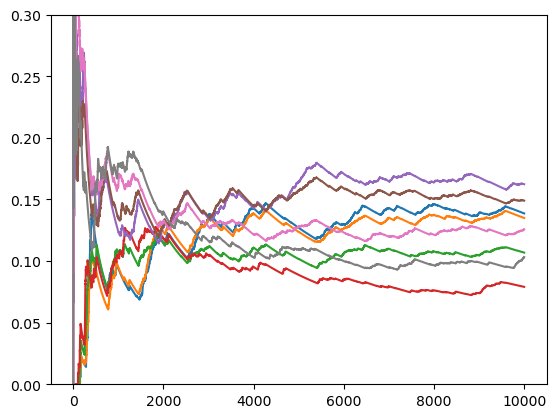

In [38]:
res_all_traj_indexed[1][1].shape
conform_num = 8
conform_p = calculate_conform_p(res_all_traj_indexed[1][1], conform_num)

plt.plot(conform_p.T)
plt.ylim(0, 0.3)

Processing all trajectories for residue 0: 100%|██████████| 85/85 [00:00<00:00, 517.57it/s]


Residue 0 — Max length: 37002


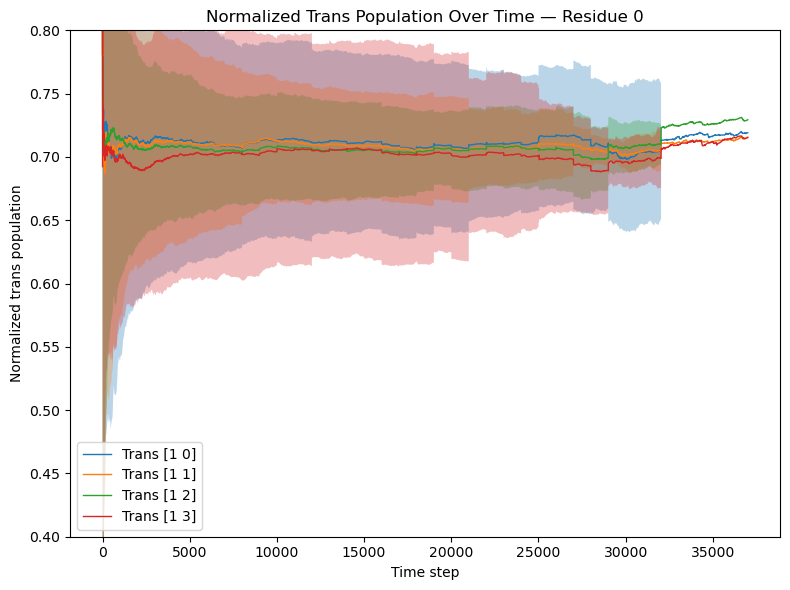

Processing all trajectories for residue 1: 100%|██████████| 85/85 [00:00<00:00, 547.27it/s]


Residue 1 — Max length: 37002


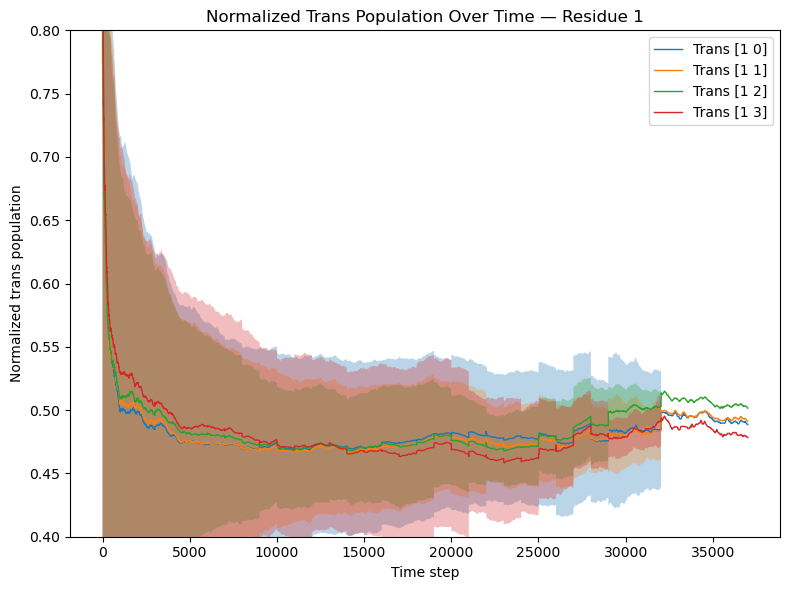

Processing all trajectories for residue 2: 100%|██████████| 85/85 [00:00<00:00, 444.06it/s]


Residue 2 — Max length: 37002


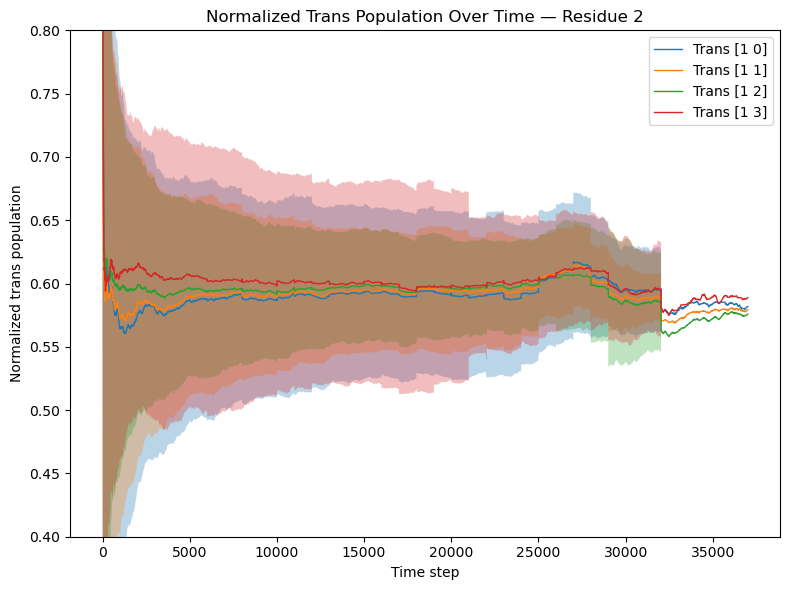

In [58]:
conform_num = 8
thermal_num = 4
n_traj = res_all_traj_indexed.shape[1]
res_num = 3

for res in range(res_num):
    # Store population results from each trajectory
    all_conform_populations = []
    res_traj_indexed = res_all_traj_indexed[res]

    for i in tqdm(range(n_traj), desc=f"Processing all trajectories for residue {res}"):
        single_traj = res_traj_indexed[i]
        conform_p = calculate_conform_p(single_traj, conform_num)
        all_conform_populations.append(conform_p)

    # Find the longest trajectory (in terms of time steps)
    maxlength = max([cp.shape[1] for cp in all_conform_populations])
    print(f"Residue {res} — Max length: {maxlength}")

    # Stack padded arrays
    all_conform_p = np.full((n_traj, conform_num, maxlength), np.nan)
    for i in range(n_traj):
        time_len = all_conform_populations[i].shape[1]
        all_conform_p[i, :, :time_len] = all_conform_populations[i]

    # Compute average and std
    avg_conform_population = np.nanmean(all_conform_p, axis=0)
    std_conform_population = np.nanstd(all_conform_p, axis=0)

    T = avg_conform_population.shape[1]
    x = np.arange(T)

    plt.figure(figsize=(8, 6))

    for i in range(thermal_num):  # i = 0, 1, 2, 3
        trans_mean = avg_conform_population[i + 4]
        trans_std = std_conform_population[i + 4]
        cis_mean = avg_conform_population[i]
        cis_std = std_conform_population[i]

        total = trans_mean + cis_mean

        with np.errstate(invalid='ignore', divide='ignore'):
            trans_mean_normalized = trans_mean / total

            # Propagated uncertainty
            trans_std_norm = trans_mean_normalized * np.sqrt(
                (trans_std / trans_mean)**2 + (cis_std / total)**2
            )

        # Plot each normalized trans state
        plt.plot(x, trans_mean_normalized, label=f"Trans {index_to_state(i + 4)}", linewidth=1)
        plt.fill_between(x,
                         trans_mean_normalized - trans_std_norm,
                         trans_mean_normalized + trans_std_norm,
                         alpha=0.3)

    plt.ylim(0.4, 0.8)
    plt.xlabel("Time step")
    plt.ylabel("Normalized trans population")
    plt.title(f"Normalized Trans Population Over Time — Residue {res}")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Plot the conformation vs ref conformation

In [59]:
df_stationary_p = pd.read_csv("autocoorel_data/trans_population_at_lagtime.csv")
#print(df_stationary_p)

    
# Pivot the DataFrame to reshape it
pivot_mean = df_stationary_p.pivot(index='state', columns='res', values='mean')
pivot_std = df_stationary_p.pivot(index='state', columns='res', values='std')

# Convert to NumPy arrays
trans_refer = pivot_mean.to_numpy()  # shape (6, 3) state, residues 
trans_refer_err = pivot_std.to_numpy()  # shape (6, 3)
trans_refer.shape

(4, 3)

Processing all trajectories for residue 0: 100%|██████████| 85/85 [00:00<00:00, 506.63it/s]


Residue 0 — Max length: 37002


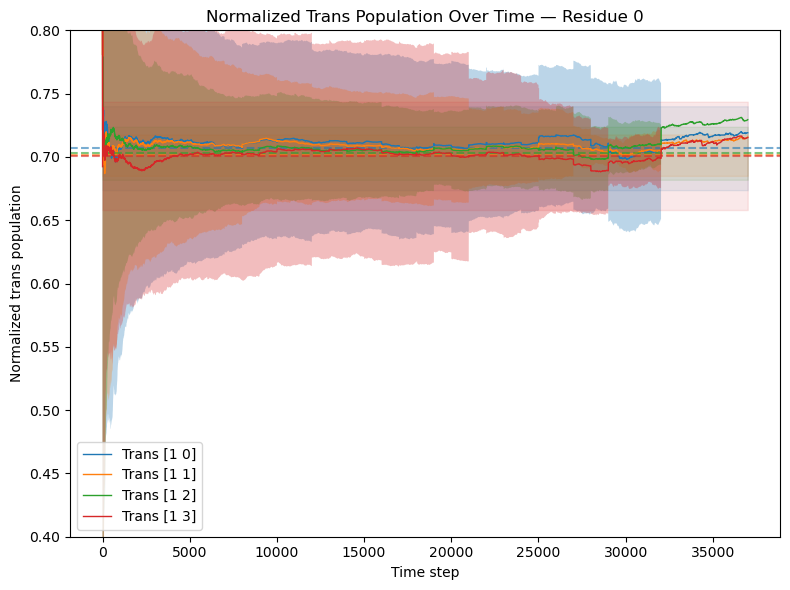

Processing all trajectories for residue 1: 100%|██████████| 85/85 [00:00<00:00, 422.67it/s]


Residue 1 — Max length: 37002


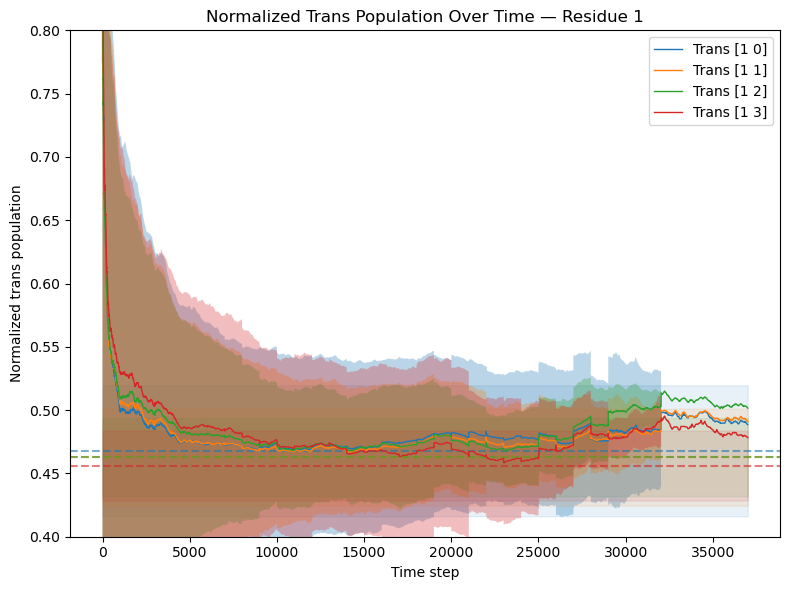

Processing all trajectories for residue 2: 100%|██████████| 85/85 [00:00<00:00, 522.40it/s]


Residue 2 — Max length: 37002


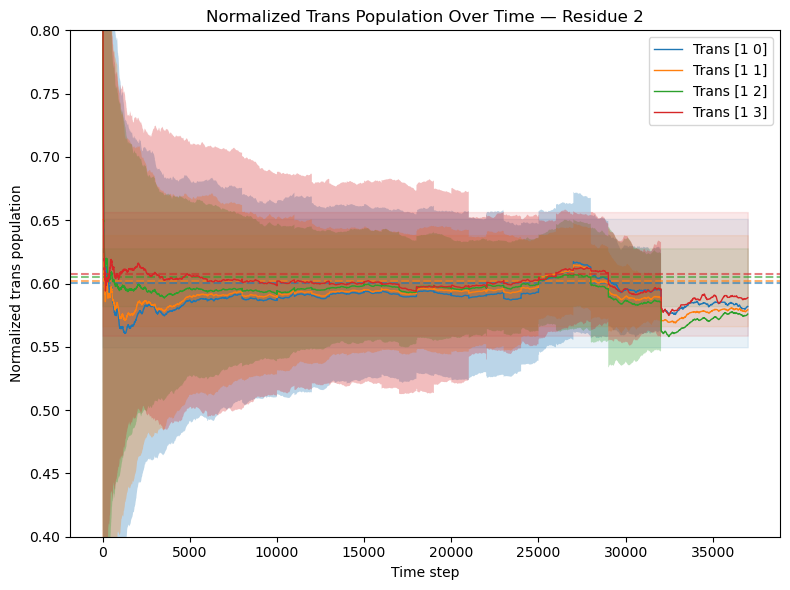

In [63]:
conform_num = 8
thermal_num = 4
#thermal_num = 1
n_traj = res_all_traj_indexed.shape[1]
res_num = 3

for res in range(res_num):
    # Store population results from each trajectory
    all_conform_populations = []
    res_traj_indexed = res_all_traj_indexed[res]

    for i in tqdm(range(n_traj), desc=f"Processing all trajectories for residue {res}"):
        single_traj = res_traj_indexed[i]
        conform_p = calculate_conform_p(single_traj, conform_num)
        all_conform_populations.append(conform_p)

    # Find the longest trajectory (in terms of time steps)
    maxlength = max([cp.shape[1] for cp in all_conform_populations])
    print(f"Residue {res} — Max length: {maxlength}")

    # Stack padded arrays
    all_conform_p = np.full((n_traj, conform_num, maxlength), np.nan)
    for i in range(n_traj):
        time_len = all_conform_populations[i].shape[1]
        all_conform_p[i, :, :time_len] = all_conform_populations[i]

    # Compute average and std
    avg_conform_population = np.nanmean(all_conform_p, axis=0)
    std_conform_population = np.nanstd(all_conform_p, axis=0)

    T = avg_conform_population.shape[1]
    x = np.arange(T)

    plt.figure(figsize=(8, 6))

    for i in range(thermal_num):  # i = 0, 1, 2, 3
        trans_mean = avg_conform_population[i + 4]
        trans_std = std_conform_population[i + 4]
        cis_mean = avg_conform_population[i]
        cis_std = std_conform_population[i]

        total = trans_mean + cis_mean

        with np.errstate(invalid='ignore', divide='ignore'):
            trans_mean_normalized = trans_mean / total

            # Propagated uncertainty
            trans_std_norm = trans_mean_normalized * np.sqrt(
                (trans_std / trans_mean)**2 + (cis_std / total)**2
            )

        # Plot each normalized trans state
        plt.plot(x, trans_mean_normalized, label=f"Trans {index_to_state(i + 4)}", linewidth=1)
        plt.fill_between(x,
                         trans_mean_normalized - trans_std_norm,
                         trans_mean_normalized + trans_std_norm,
                         alpha=0.3)
        
        # Reference line
        ref_y = trans_refer[i, res]
        ref_yerr = trans_refer_err[i, res]

        plt.axhline(y=ref_y, linestyle='--', color=f'C{i}', alpha=0.6)
        plt.fill_between(
            x,
            ref_y - ref_yerr,
            ref_y + ref_yerr,
            color=f'C{i}',
            alpha=0.1
        )

    plt.ylim(0.4, 0.8)
    plt.xlabel("Time step")
    plt.ylabel("Normalized trans population")
    plt.title(f"Normalized Trans Population Over Time — Residue {res}")
    plt.legend()
    plt.tight_layout()
    plt.show()


Processing trajectories for residue 0: 100%|██████████| 85/85 [00:00<00:00, 295.99it/s]


Residue 0 — Max length: 37002


Processing trajectories for residue 1: 100%|██████████| 85/85 [00:00<00:00, 332.74it/s]


Residue 1 — Max length: 37002


Processing trajectories for residue 2: 100%|██████████| 85/85 [00:00<00:00, 543.33it/s]


Residue 2 — Max length: 37002


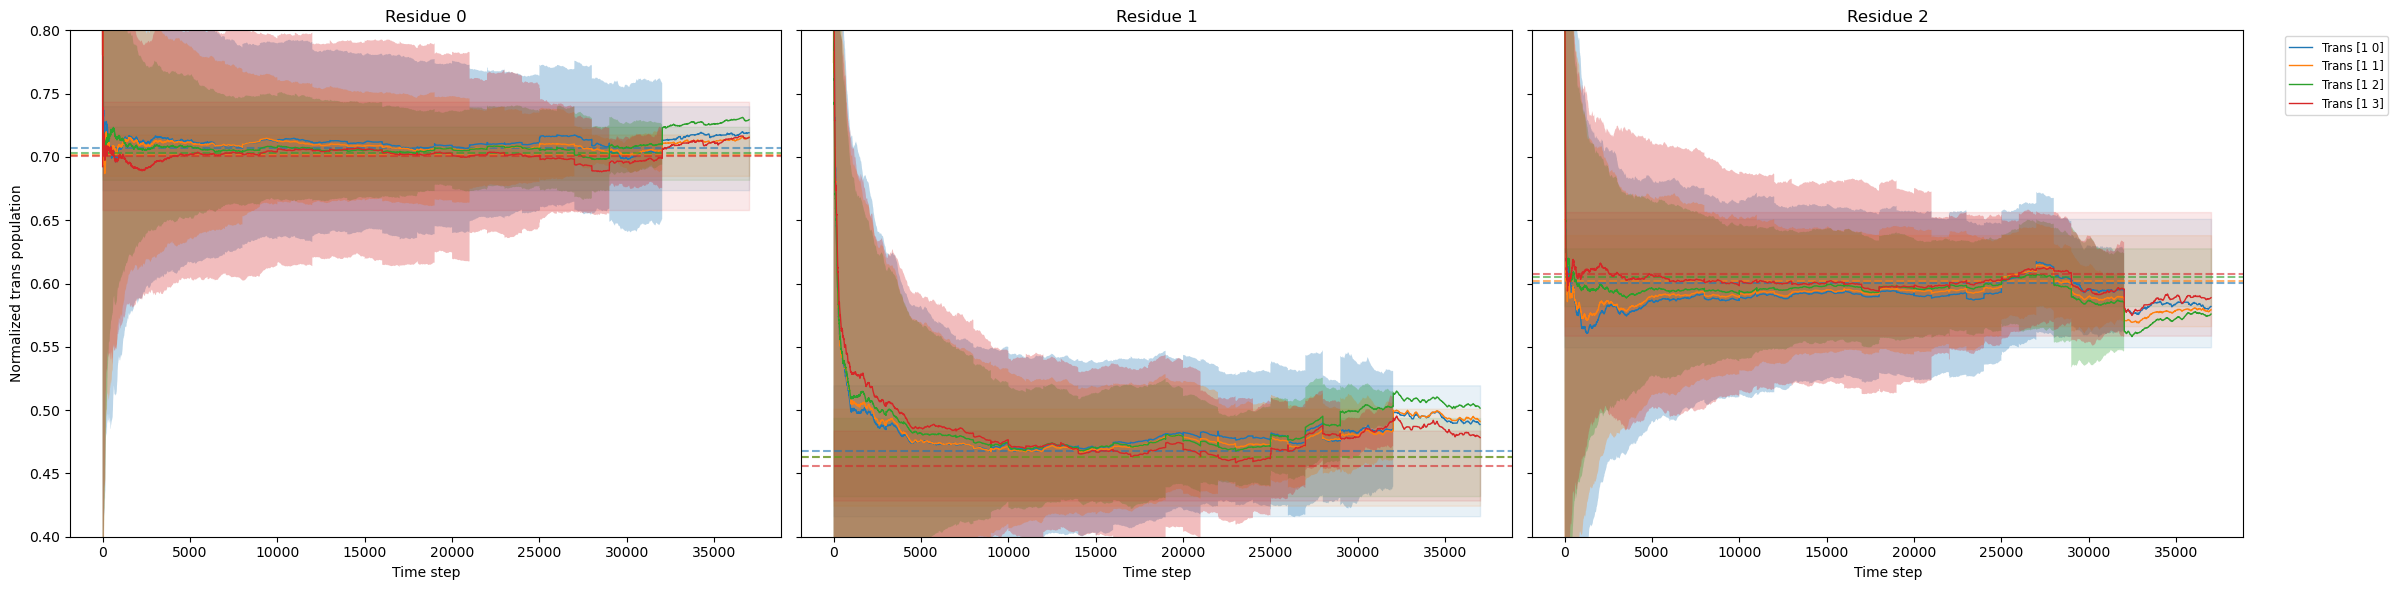

In [69]:
import matplotlib.pyplot as plt
import numpy as np

conform_num = 8
thermal_num = 4
n_traj = res_all_traj_indexed.shape[1]
res_num = 3

fig, axes = plt.subplots(1, res_num, figsize=(24, 6), sharey=True)
x_shared = None  # Will be initialized with actual x once known

for res in range(res_num):
    ax = axes[res]
    
    # Store population results from each trajectory
    all_conform_populations = []
    res_traj_indexed = res_all_traj_indexed[res]

    for i in tqdm(range(n_traj), desc=f"Processing trajectories for residue {res}"):
        single_traj = res_traj_indexed[i]
        conform_p = calculate_conform_p(single_traj, conform_num)
        all_conform_populations.append(conform_p)

    maxlength = max([cp.shape[1] for cp in all_conform_populations])
    print(f"Residue {res} — Max length: {maxlength}")

    all_conform_p = np.full((n_traj, conform_num, maxlength), np.nan)
    for i in range(n_traj):
        time_len = all_conform_populations[i].shape[1]
        all_conform_p[i, :, :time_len] = all_conform_populations[i]

    avg_conform_population = np.nanmean(all_conform_p, axis=0)
    std_conform_population = np.nanstd(all_conform_p, axis=0)

    T = avg_conform_population.shape[1]
    x = np.arange(T)
    x_shared = x  # Save for consistency across subplots

    for i in range(thermal_num):  # i = 0, 1, 2, 3
        trans_mean = avg_conform_population[i + 4]
        trans_std = std_conform_population[i + 4]
        cis_mean = avg_conform_population[i]
        cis_std = std_conform_population[i]

        total = trans_mean + cis_mean

        with np.errstate(invalid='ignore', divide='ignore'):
            trans_mean_normalized = trans_mean / total
            trans_std_norm = trans_mean_normalized * np.sqrt(
                (trans_std / trans_mean)**2 + (cis_std / total)**2
            )

        ax.plot(x, trans_mean_normalized, label=f"Trans {index_to_state(i + 4)}", linewidth=1)
        ax.fill_between(x,
                        trans_mean_normalized - trans_std_norm,
                        trans_mean_normalized + trans_std_norm,
                        alpha=0.3)

        # Reference line
        ref_y = trans_refer[i, res]
        ref_yerr = trans_refer_err[i, res]

        ax.axhline(y=ref_y, linestyle='--', color=f'C{i}', alpha=0.6)
        ax.fill_between(x,
                        ref_y - ref_yerr,
                        ref_y + ref_yerr,
                        color=f'C{i}', alpha=0.1)

    ax.set_title(f"Residue {res}")
    ax.set_xlabel("Time step")
    if res == 0:
        ax.set_ylabel("Normalized trans population")
    ax.set_ylim(0.4, 0.8)

# Legend outside the last subplot
axes[-1].legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')

plt.tight_layout()
plt.show()


Processing trajectories for residue 2: 100%|██████████| 85/85 [00:00<00:00, 529.59it/s]


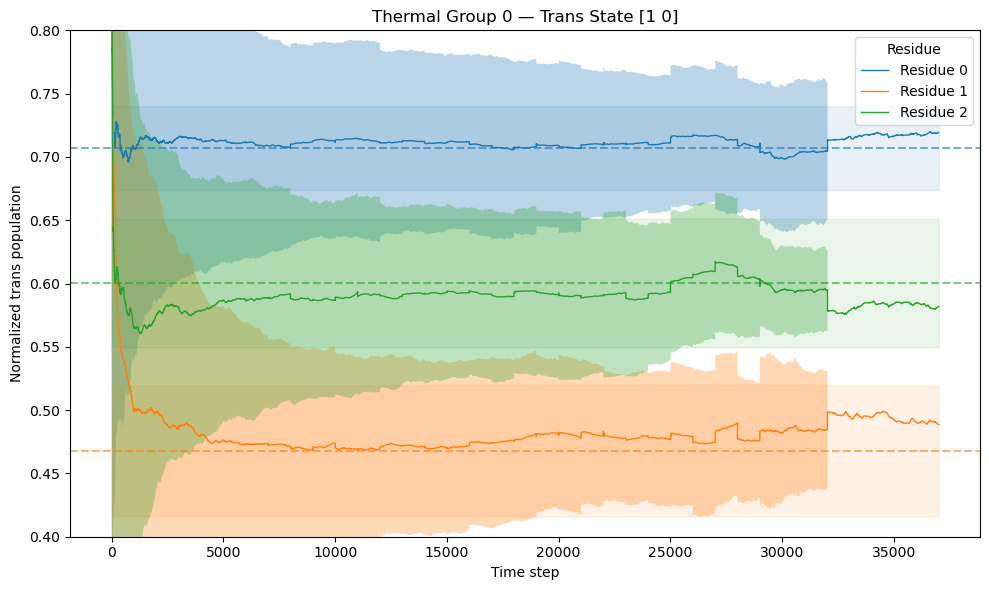

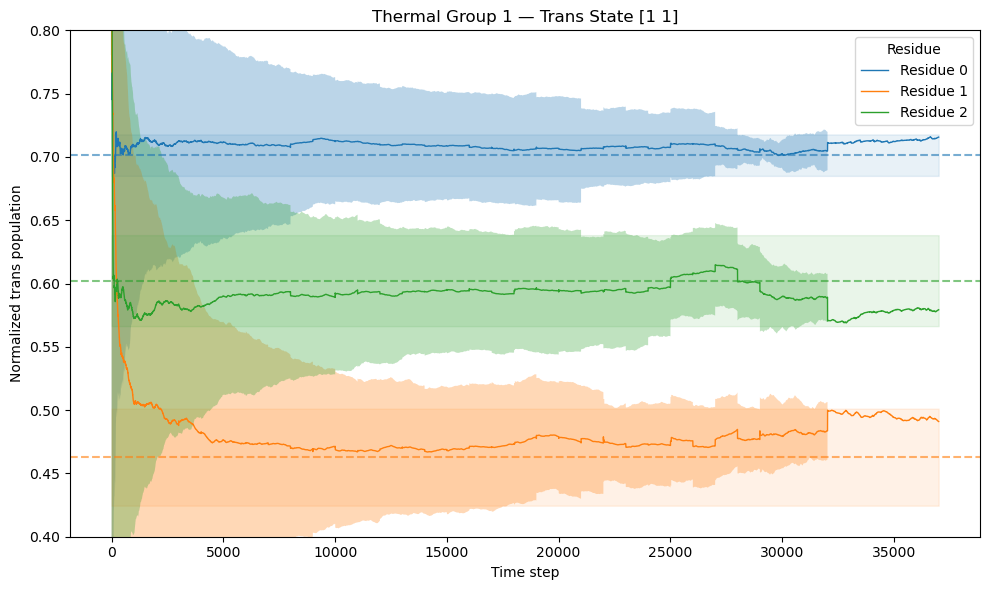

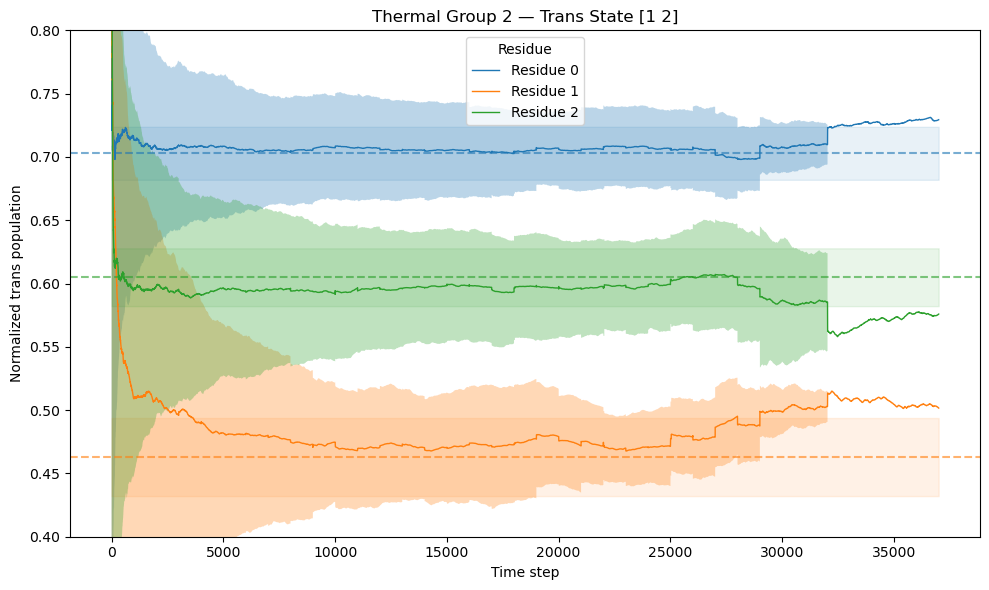

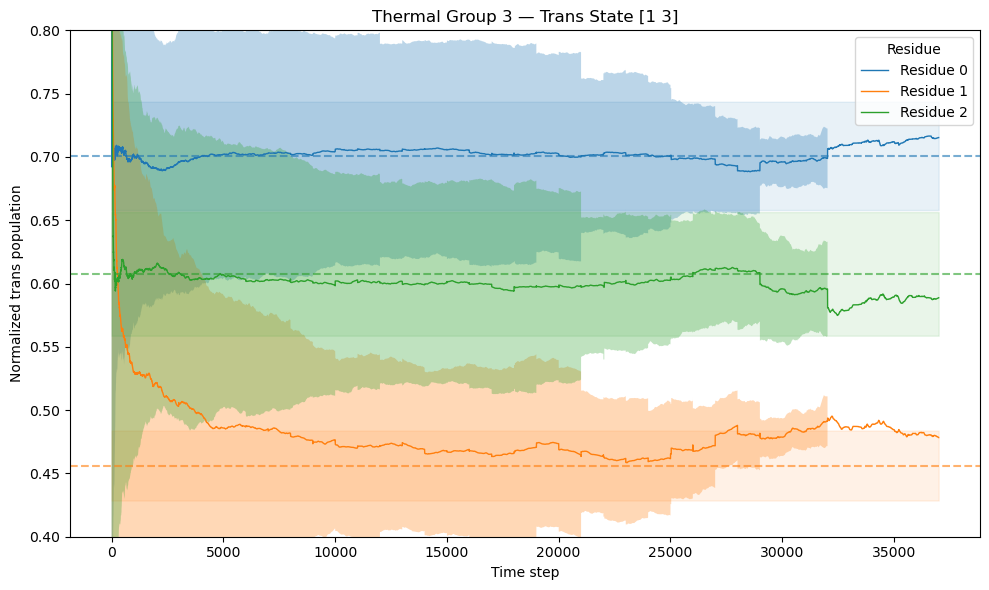

In [75]:
import matplotlib.pyplot as plt
import numpy as np

conform_num = 8
thermal_num = 4
n_traj = res_all_traj_indexed.shape[1]
res_num = 3

# Precompute all conformational populations for all residues
res_conform_data = []
for res in range(res_num):
    all_conform_populations = []
    res_traj_indexed = res_all_traj_indexed[res]

    for i in tqdm(range(n_traj), desc=f"Processing trajectories for residue {res}"):
        single_traj = res_traj_indexed[i]
        conform_p = calculate_conform_p(single_traj, conform_num)
        all_conform_populations.append(conform_p)

    maxlength = max([cp.shape[1] for cp in all_conform_populations])
    all_conform_p = np.full((n_traj, conform_num, maxlength), np.nan)

    for i in range(n_traj):
        time_len = all_conform_populations[i].shape[1]
        all_conform_p[i, :, :time_len] = all_conform_populations[i]

    # Store for use later
    avg_conform = np.nanmean(all_conform_p, axis=0)
    std_conform = np.nanstd(all_conform_p, axis=0)
    res_conform_data.append((avg_conform, std_conform))

# Use time from first residue
T = res_conform_data[0][0].shape[1]
x = np.arange(T)

# One plot per thermal group
for i in range(thermal_num):  # i = 0, 1, 2, 3
    plt.figure(figsize=(10, 6))

    for res in range(res_num):
        avg_conform_population, std_conform_population = res_conform_data[res]

        trans_mean = avg_conform_population[i + 4]
        trans_std = std_conform_population[i + 4]
        cis_mean = avg_conform_population[i]
        cis_std = std_conform_population[i]

        total = trans_mean + cis_mean

        with np.errstate(invalid='ignore', divide='ignore'):
            trans_mean_normalized = trans_mean / total
            trans_std_norm = trans_mean_normalized * np.sqrt(
                (trans_std / trans_mean)**2 + (cis_std / total)**2
            )

        plt.plot(x, trans_mean_normalized, label=f"Residue {res}", linewidth=1)
        plt.fill_between(x,
                         trans_mean_normalized - trans_std_norm,
                         trans_mean_normalized + trans_std_norm,
                         alpha=0.3)

        # Reference line
        ref_y = trans_refer[i, res]
        ref_yerr = trans_refer_err[i, res]

        plt.axhline(y=ref_y, linestyle='--', color=f'C{res}', alpha=0.6)
        plt.fill_between(x,
                         ref_y - ref_yerr,
                         ref_y + ref_yerr,
                         color=f'C{res}', alpha=0.1)

    plt.title(f"Thermal Group {i} — Trans State {index_to_state(i + 4)}")
    plt.xlabel("Time step")
    plt.ylabel("Normalized trans population")
    plt.ylim(0.4, 0.8)
    plt.legend(title="Residue")
    plt.tight_layout()
    plt.show()


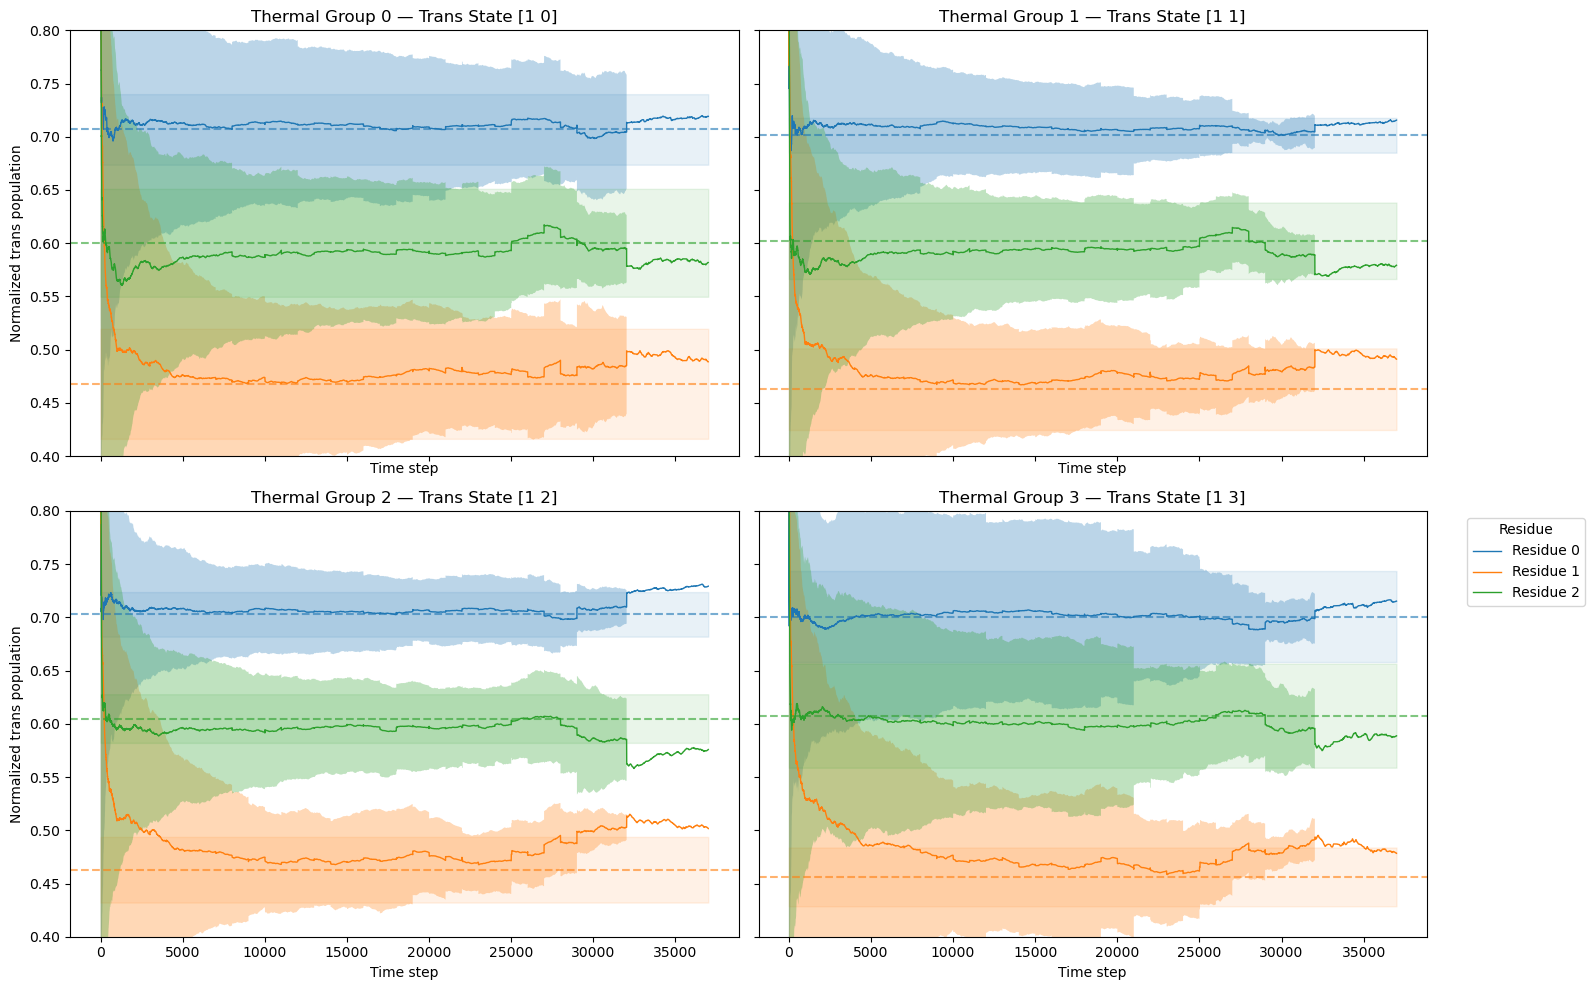

In [77]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(thermal_num):
    ax = axes[i]
    for res in range(res_num):
        avg_conform_population, std_conform_population = res_conform_data[res]

        trans_mean = avg_conform_population[i + 4]
        trans_std = std_conform_population[i + 4]
        cis_mean = avg_conform_population[i]
        cis_std = std_conform_population[i]

        total = trans_mean + cis_mean

        with np.errstate(invalid='ignore', divide='ignore'):
            trans_mean_normalized = trans_mean / total
            trans_std_norm = trans_mean_normalized * np.sqrt(
                (trans_std / trans_mean)**2 + (cis_std / total)**2
            )

        ax.plot(x, trans_mean_normalized, label=f"Residue {res}", linewidth=1)
        ax.fill_between(x,
                        trans_mean_normalized - trans_std_norm,
                        trans_mean_normalized + trans_std_norm,
                        alpha=0.3)

        # Reference line
        ref_y = trans_refer[i, res]
        ref_yerr = trans_refer_err[i, res]

        ax.axhline(y=ref_y, linestyle='--', color=f'C{res}', alpha=0.6)
        ax.fill_between(x,
                        ref_y - ref_yerr,
                        ref_y + ref_yerr,
                        color=f'C{res}', alpha=0.1)

    ax.set_title(f"Thermal Group {i} — Trans State {index_to_state(i + 4)}")
    ax.set_ylim(0.4, 0.8)
    ax.set_xlabel("Time step")
    if i % 2 == 0:
        ax.set_ylabel("Normalized trans population")

axes[-1].legend(title="Residue", loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


## Plot the Error

Processing all trajectories for residue 0: 100%|██████████| 85/85 [00:00<00:00, 406.91it/s]


Residue 0 — Max length: 37002


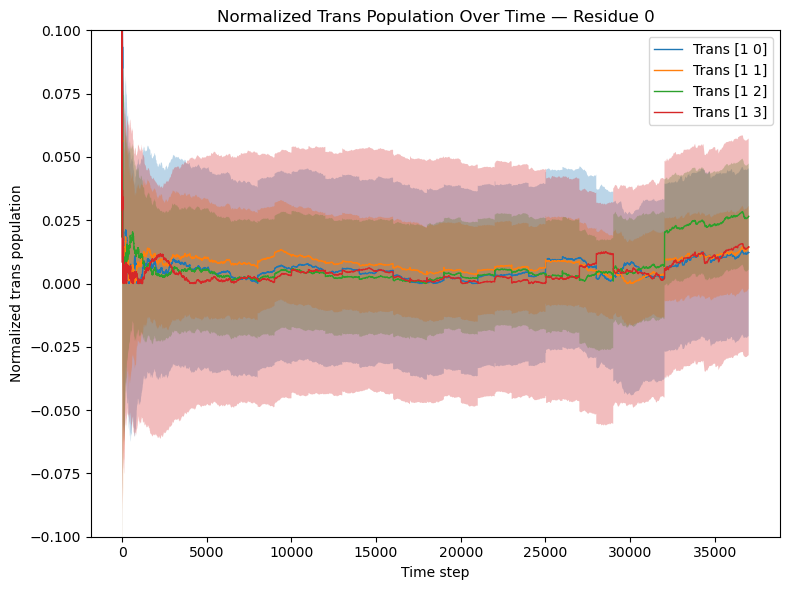

Processing all trajectories for residue 1: 100%|██████████| 85/85 [00:00<00:00, 555.94it/s]


Residue 1 — Max length: 37002


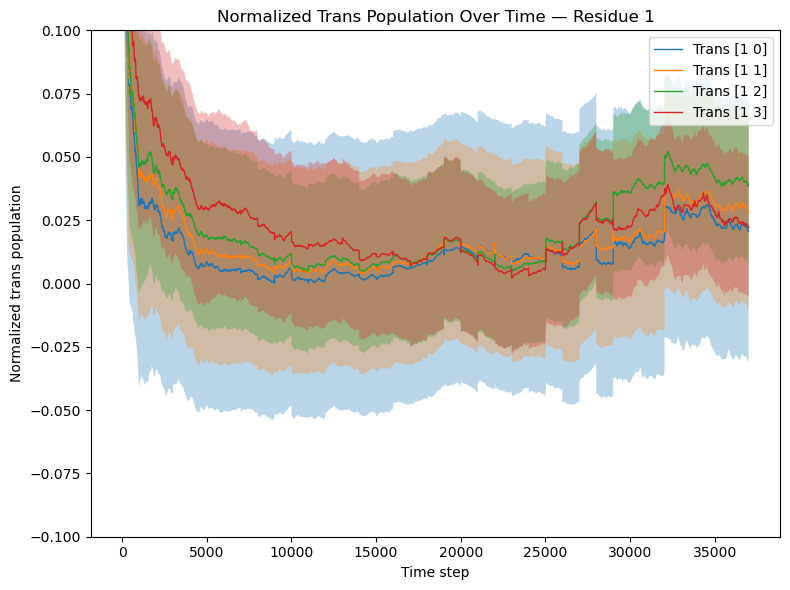

Processing all trajectories for residue 2: 100%|██████████| 85/85 [00:00<00:00, 472.75it/s]


Residue 2 — Max length: 37002


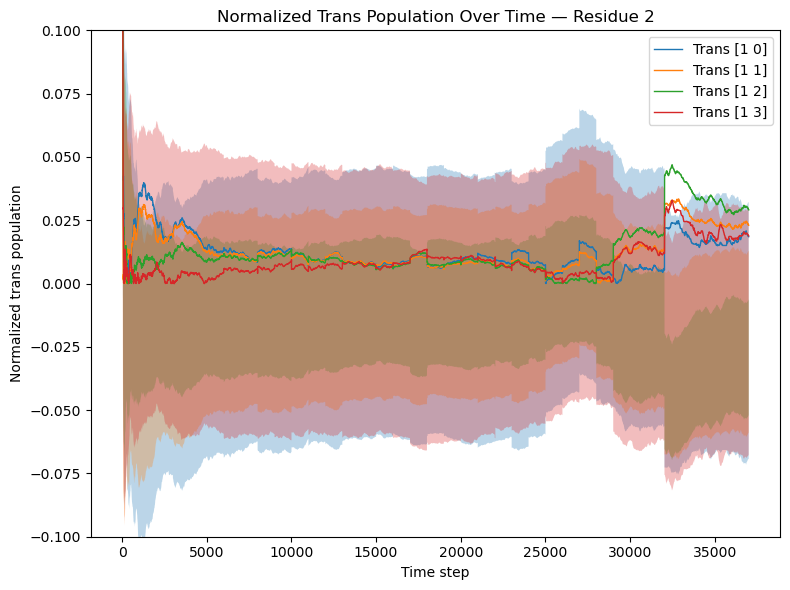

In [67]:
conform_num = 8
thermal_num = 4
#thermal_num = 1
n_traj = res_all_traj_indexed.shape[1]
res_num = 3

for res in range(res_num):
    # Store population results from each trajectory
    all_conform_populations = []
    res_traj_indexed = res_all_traj_indexed[res]

    for i in tqdm(range(n_traj), desc=f"Processing all trajectories for residue {res}"):
        single_traj = res_traj_indexed[i]
        conform_p = calculate_conform_p(single_traj, conform_num)
        all_conform_populations.append(conform_p)

    # Find the longest trajectory (in terms of time steps)
    maxlength = max([cp.shape[1] for cp in all_conform_populations])
    print(f"Residue {res} — Max length: {maxlength}")

    # Stack padded arrays
    all_conform_p = np.full((n_traj, conform_num, maxlength), np.nan)
    for i in range(n_traj):
        time_len = all_conform_populations[i].shape[1]
        all_conform_p[i, :, :time_len] = all_conform_populations[i]

    # Compute average and std
    avg_conform_population = np.nanmean(all_conform_p, axis=0)
    std_conform_population = np.nanstd(all_conform_p, axis=0)

    T = avg_conform_population.shape[1]
    x = np.arange(T)

    plt.figure(figsize=(8, 6))

    for i in range(thermal_num):  # i = 0, 1, 2, 3
        trans_mean = avg_conform_population[i + 4]
        trans_std = std_conform_population[i + 4]
        cis_mean = avg_conform_population[i]
        cis_std = std_conform_population[i]

        total = trans_mean + cis_mean

        with np.errstate(invalid='ignore', divide='ignore'):
            trans_mean_normalized = trans_mean / total

            # Propagated uncertainty
            trans_std_norm = trans_mean_normalized * np.sqrt(
                (trans_std / trans_mean)**2 + (cis_std / total)**2
            )

        # Reference line
        ref_y = trans_refer[i, res]
        ref_yerr = trans_refer_err[i, res]

    

        error = trans_mean_normalized - ref_y
        error_abs = np.abs(error)
        error_err = np.sqrt(
            trans_std ** 2 + ref_yerr ** 2 
        )
        plt.plot(x, error_abs, label=f"Trans {index_to_state(i + 4)}", linewidth=1)
        plt.fill_between(x,
                         error - error_err,
                         error + error_err,
                         alpha=0.3)


    plt.ylim(-0.1, 0.1)
    plt.xlabel("Time step")
    plt.ylabel("Normalized trans population")
    plt.title(f"Normalized Trans Population Over Time — Residue {res}")
    plt.legend()
    plt.tight_layout()
    plt.show()


Processing trajectories for residue 2: 100%|██████████| 85/85 [00:00<00:00, 543.40it/s]


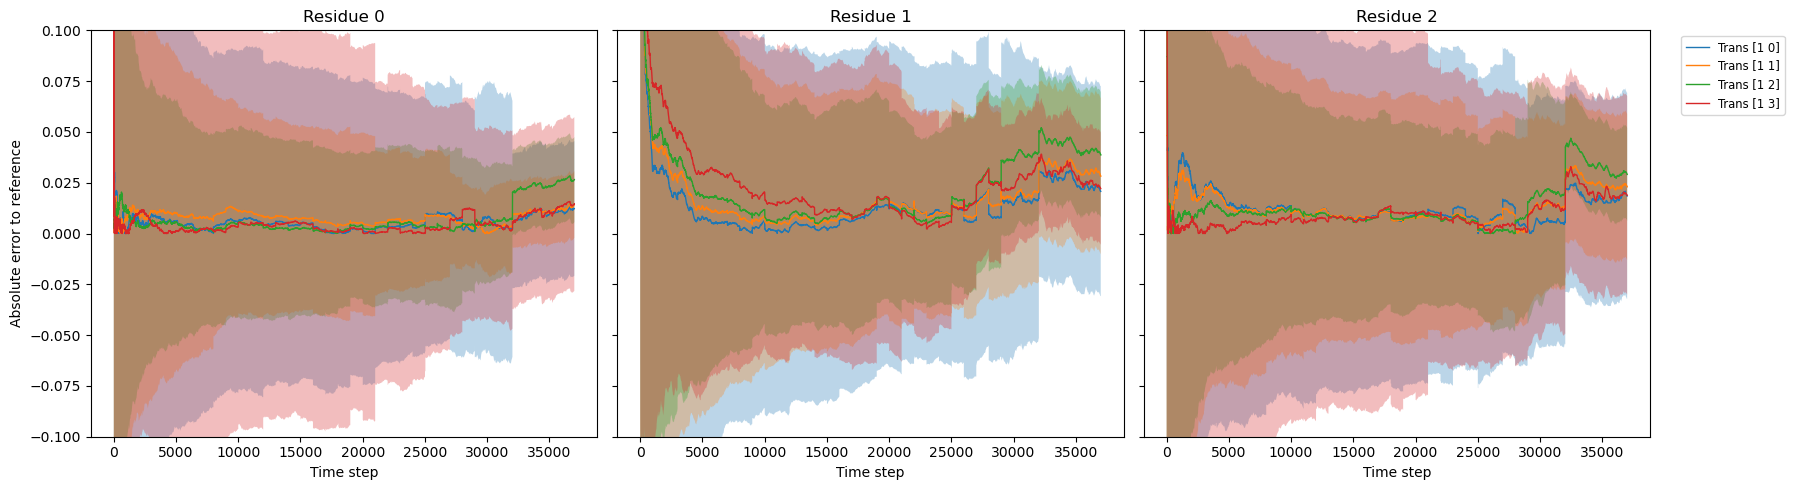

In [70]:
import matplotlib.pyplot as plt
import numpy as np

conform_num = 8
thermal_num = 4
n_traj = res_all_traj_indexed.shape[1]
res_num = 3

fig, axes = plt.subplots(1, res_num, figsize=(18, 5), sharey=True)
axes = axes.flatten()

for res in range(res_num):
    ax = axes[res]

    # Store population results from each trajectory
    all_conform_populations = []
    res_traj_indexed = res_all_traj_indexed[res]

    for i in tqdm(range(n_traj), desc=f"Processing trajectories for residue {res}"):
        single_traj = res_traj_indexed[i]
        conform_p = calculate_conform_p(single_traj, conform_num)
        all_conform_populations.append(conform_p)

    maxlength = max([cp.shape[1] for cp in all_conform_populations])
    all_conform_p = np.full((n_traj, conform_num, maxlength), np.nan)
    for i in range(n_traj):
        time_len = all_conform_populations[i].shape[1]
        all_conform_p[i, :, :time_len] = all_conform_populations[i]

    avg_conform_population = np.nanmean(all_conform_p, axis=0)
    std_conform_population = np.nanstd(all_conform_p, axis=0)

    T = avg_conform_population.shape[1]
    x = np.arange(T)

    for i in range(thermal_num):  # i = 0, 1, 2, 3
        trans_mean = avg_conform_population[i + 4]
        trans_std = std_conform_population[i + 4]
        cis_mean = avg_conform_population[i]
        cis_std = std_conform_population[i]

        total = trans_mean + cis_mean

        with np.errstate(invalid='ignore', divide='ignore'):
            trans_mean_normalized = trans_mean / total
            trans_std_norm = trans_mean_normalized * np.sqrt(
                (trans_std / trans_mean)**2 + (cis_std / total)**2
            )

        # Reference line values
        ref_y = trans_refer[i, res]
        ref_yerr = trans_refer_err[i, res]

        # Absolute error and propagated uncertainty
        error = trans_mean_normalized - ref_y
        error_abs = np.abs(error)
        error_err = np.sqrt(trans_std_norm**2 + ref_yerr**2)

        ax.plot(x, error_abs, label=f"Trans {index_to_state(i + 4)}", linewidth=1)
        ax.fill_between(x, error_abs - error_err, error_abs + error_err, alpha=0.3)

    ax.set_ylim(-0.1, 0.1)
    ax.set_title(f"Residue {res}")
    ax.set_xlabel("Time step")
    if res == 0:
        ax.set_ylabel("Absolute error to reference")

# Put legend outside last subplot
axes[-1].legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')

plt.tight_layout()
plt.show()


Processing trajectories for residue 2: 100%|██████████| 85/85 [00:00<00:00, 591.65it/s]


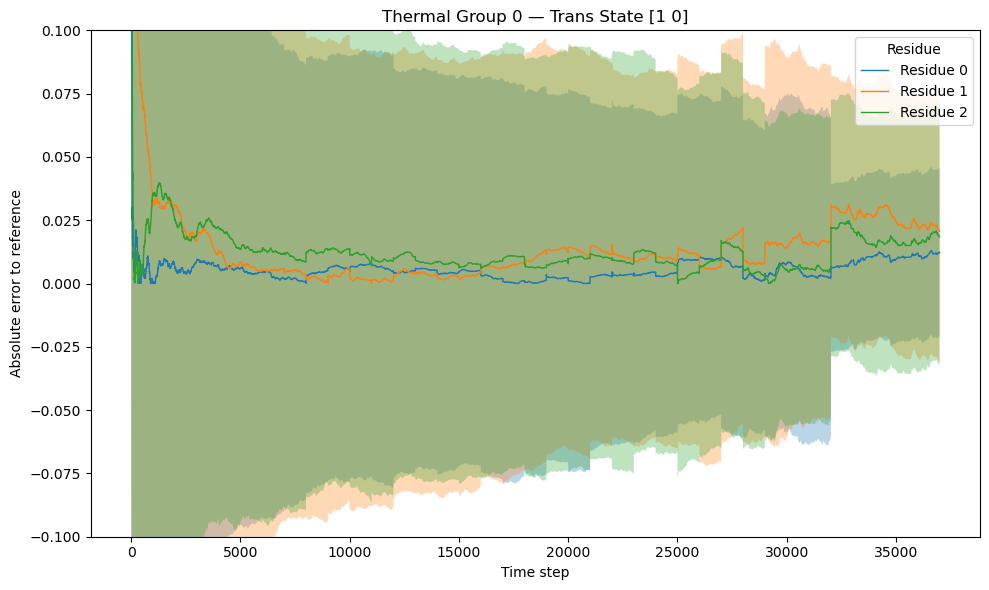

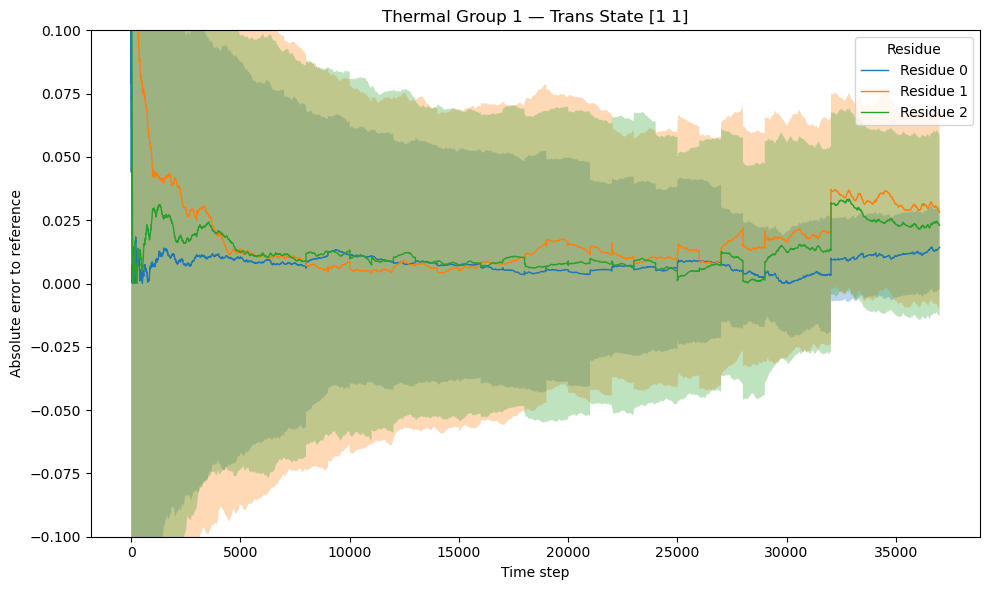

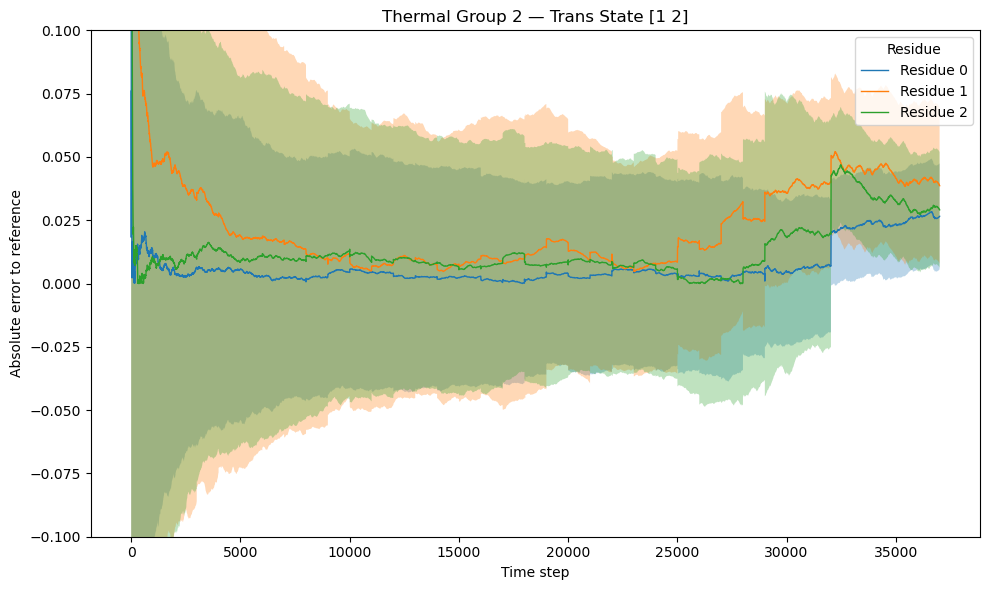

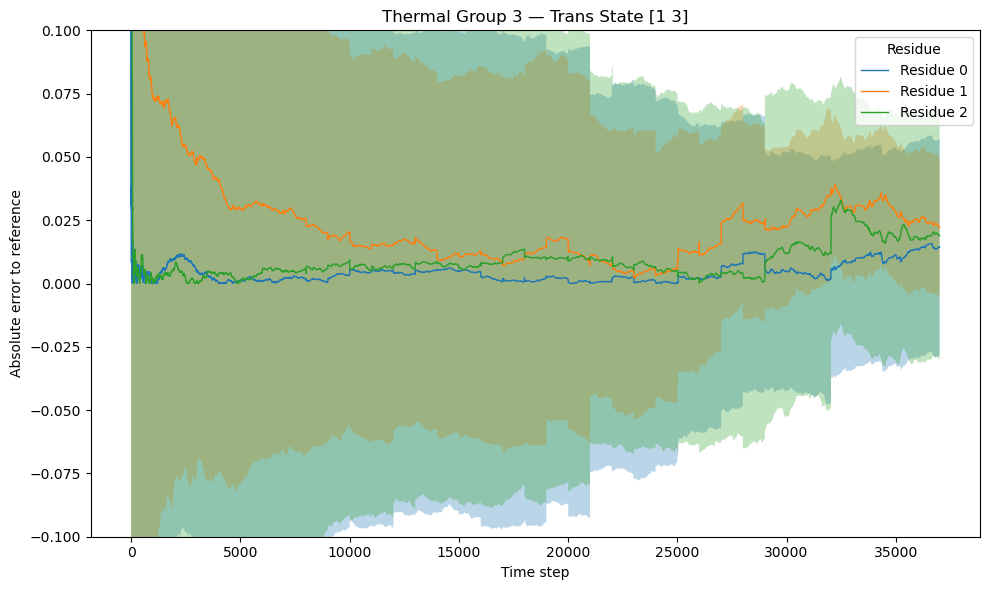

In [73]:
import matplotlib.pyplot as plt
import numpy as np

conform_num = 8
thermal_num = 4
n_traj = res_all_traj_indexed.shape[1]
res_num = 3

# Precompute all conformational populations for all residues
res_conform_data = []
for res in range(res_num):
    all_conform_populations = []
    res_traj_indexed = res_all_traj_indexed[res]

    for i in tqdm(range(n_traj), desc=f"Processing trajectories for residue {res}"):
        single_traj = res_traj_indexed[i]
        conform_p = calculate_conform_p(single_traj, conform_num)
        all_conform_populations.append(conform_p)

    maxlength = max([cp.shape[1] for cp in all_conform_populations])
    all_conform_p = np.full((n_traj, conform_num, maxlength), np.nan)

    for i in range(n_traj):
        time_len = all_conform_populations[i].shape[1]
        all_conform_p[i, :, :time_len] = all_conform_populations[i]

    avg_conform_population = np.nanmean(all_conform_p, axis=0)
    std_conform_population = np.nanstd(all_conform_p, axis=0)

    res_conform_data.append((avg_conform_population, std_conform_population))

T = res_conform_data[0][0].shape[1]
x = np.arange(T)

# One plot per thermal group
for i in range(thermal_num):  # i = 0, 1, 2, 3
    plt.figure(figsize=(10, 6))

    for res in range(res_num):
        avg_conform_population, std_conform_population = res_conform_data[res]

        trans_mean = avg_conform_population[i + 4]
        trans_std = std_conform_population[i + 4]
        cis_mean = avg_conform_population[i]
        cis_std = std_conform_population[i]

        total = trans_mean + cis_mean

        with np.errstate(invalid='ignore', divide='ignore'):
            trans_mean_normalized = trans_mean / total
            trans_std_norm = trans_mean_normalized * np.sqrt(
                (trans_std / trans_mean)**2 + (cis_std / total)**2
            )

        # Reference values
        ref_y = trans_refer[i, res]
        ref_yerr = trans_refer_err[i, res]

        # Absolute error and error propagation
        error = trans_mean_normalized - ref_y
        error_abs = np.abs(error)
        error_err = np.sqrt(trans_std_norm**2 + ref_yerr**2)

        plt.plot(x, error_abs, label=f"Residue {res}", linewidth=1)
        plt.fill_between(x, error_abs - error_err, error_abs + error_err, alpha=0.3)

    plt.ylim(-0.1, 0.1)
    plt.xlabel("Time step")
    plt.ylabel("Absolute error to reference")
    plt.title(f"Thermal Group {i} — Trans State {index_to_state(i + 4)}")
    plt.legend(title="Residue")
    plt.tight_layout()
    plt.show()


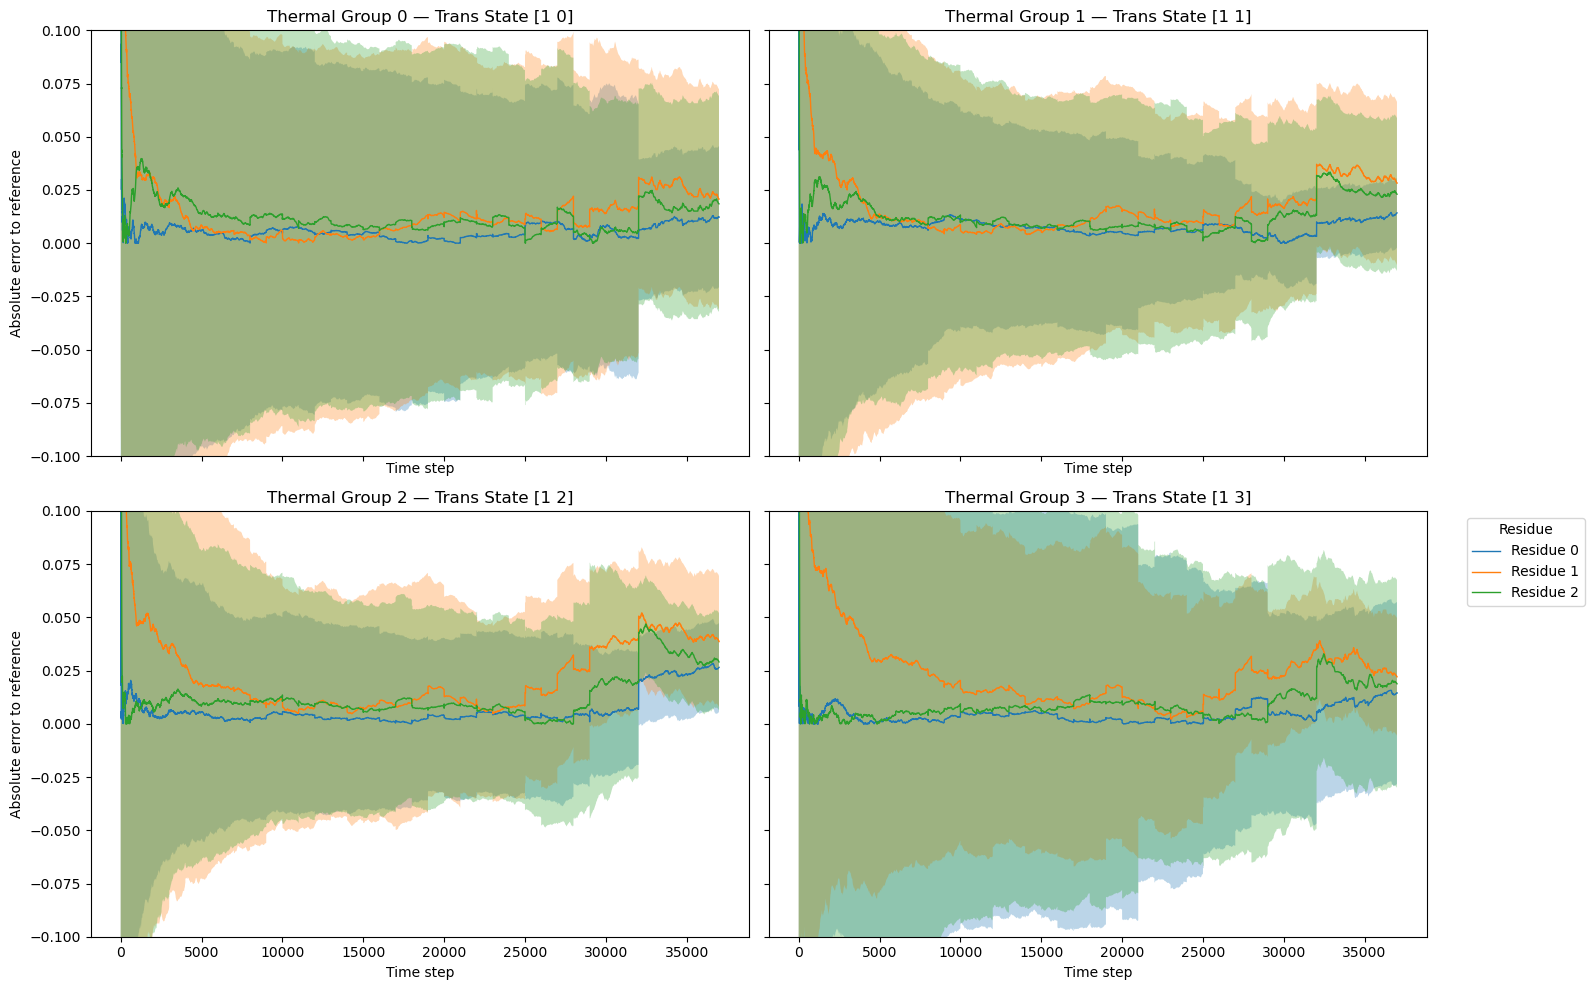

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(thermal_num):
    ax = axes[i]
    for res in range(res_num):
        avg_conform_population, std_conform_population = res_conform_data[res]

        trans_mean = avg_conform_population[i + 4]
        trans_std = std_conform_population[i + 4]
        cis_mean = avg_conform_population[i]
        cis_std = std_conform_population[i]

        total = trans_mean + cis_mean

        with np.errstate(invalid='ignore', divide='ignore'):
            trans_mean_normalized = trans_mean / total
            trans_std_norm = trans_mean_normalized * np.sqrt(
                (trans_std / trans_mean)**2 + (cis_std / total)**2
            )

        # Reference values
        ref_y = trans_refer[i, res]
        ref_yerr = trans_refer_err[i, res]

        # Absolute error and propagated uncertainty
        error = trans_mean_normalized - ref_y
        error_abs = np.abs(error)
        error_err = np.sqrt(trans_std_norm**2 + ref_yerr**2)

        ax.plot(x, error_abs, label=f"Residue {res}", linewidth=1)
        ax.fill_between(x, error_abs - error_err, error_abs + error_err, alpha=0.3)

    ax.set_title(f"Thermal Group {i} — Trans State {index_to_state(i + 4)}")
    ax.set_ylim(-0.1, 0.1)
    ax.set_xlabel("Time step")
    if i % 2 == 0:
        ax.set_ylabel("Absolute error to reference")

axes[-1].legend(title="Residue", loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()
